In [1]:
import gpmultipy, scipy, string
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear

In [3]:
%matplotlib inline

In [4]:
def wellPosition(number):
    number = int(number)
    if number > 100:
        return wellPosition(number%100)
    if number == 0:
        return 9,9
    return [(number-1) % 10, (number-1)/10]

In [54]:
ds = dataset.DataSet('data/')
# x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',Bio='F',effects=['Well'])
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',effects=['Well'])
y = np.log2(y)

x = x[6:,:]
y = y[6:,:]

In [55]:
position = np.array(map(wellPosition,labels[0]))
dist = np.column_stack((position.min(1),(9-position).min(1))).min(1)

In [56]:
select = dist != 0
y = y[:,select]
y = (y-y.mean())/y.std()

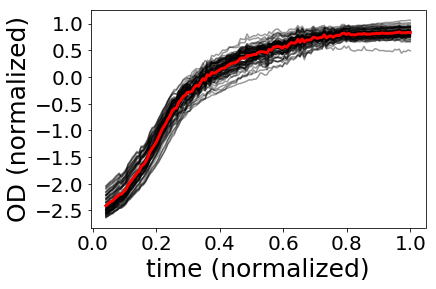

In [62]:
plt.plot(x,y,c='k',alpha=.4); plt.plot(x,y.mean(1),c='r',lw=3);
plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("figures/data-techReplicate.pdf",bbox_inches='tight',dpi=300)

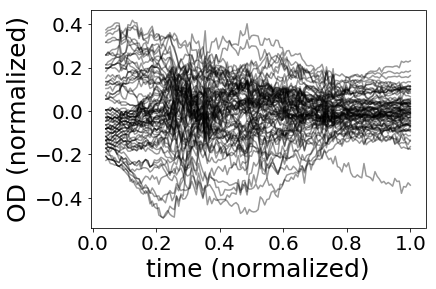

In [60]:
plt.figure(figsize=(6,4))

plt.plot(x,y-y.mean(1)[:,None],c='k',alpha=.4)

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("figures/residuals-techReplicate.pdf",bbox_inches='tight')

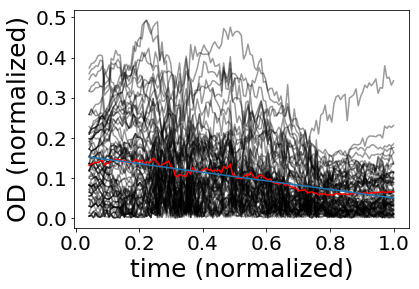

In [61]:
plt.figure(figsize=(6,4))

resid = y-y.mean(1)[:,None]
plt.plot(x,abs(resid),c='k',alpha=.4);
plt.plot(x,abs(resid).mean(1),c='r',alpha=1);

A = np.ones((x.shape[0],2))
A[:,1] = x[:,0]
beta,_,_,_ = np.linalg.lstsq(A,abs(resid).mean(1))
plt.plot(x,np.dot(A,beta))

# plt.ylim(-.1,1)

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("figures/residual-mean-techReplicate.pdf",bbox_inches='tight')

/home/ptonner/dev/experimental-variation/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


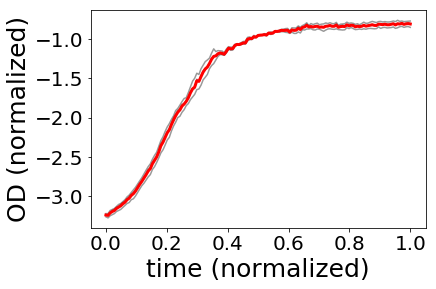

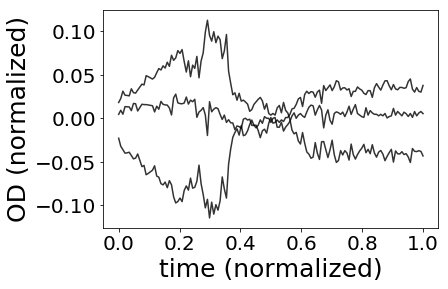

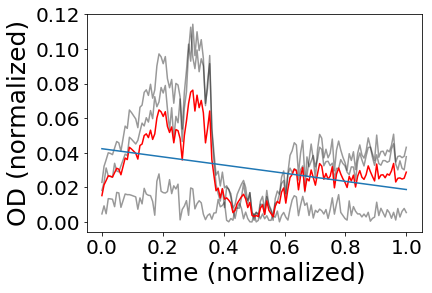

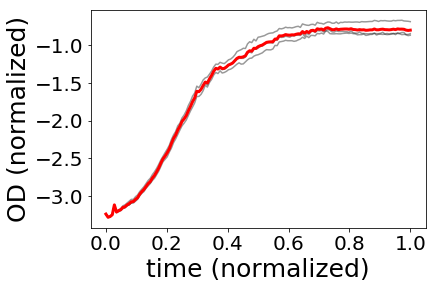

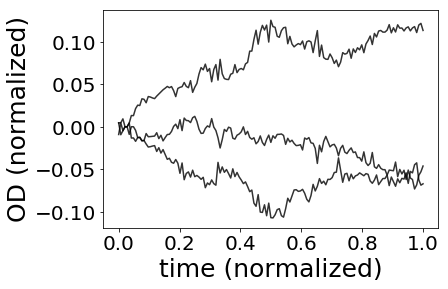

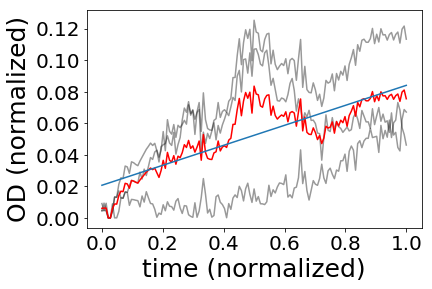

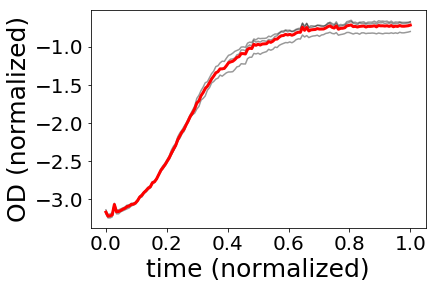

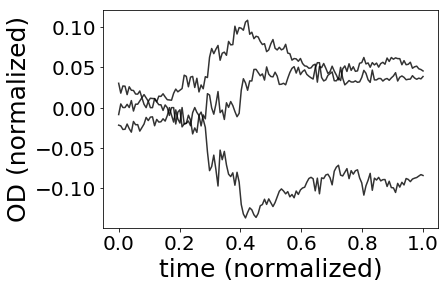

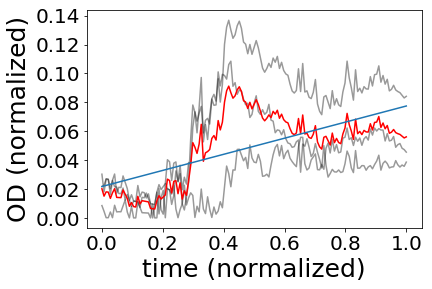

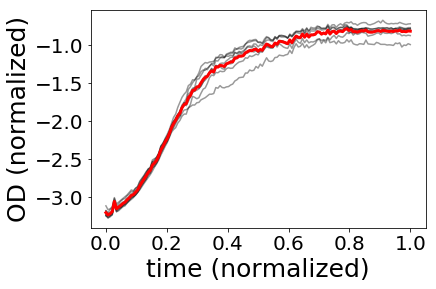

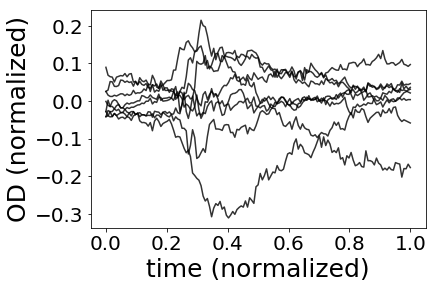

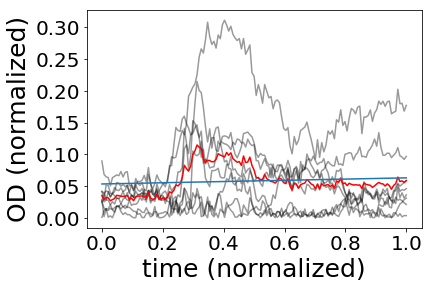

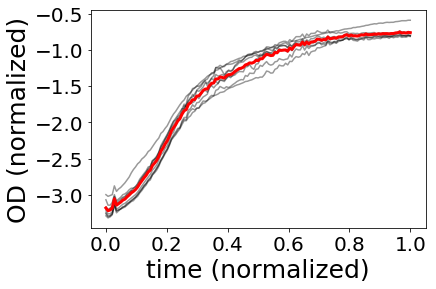

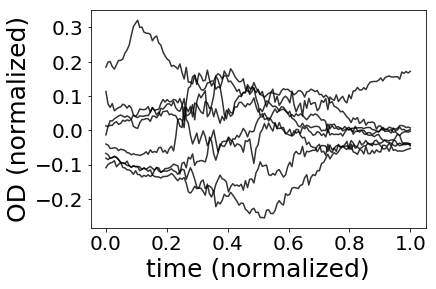

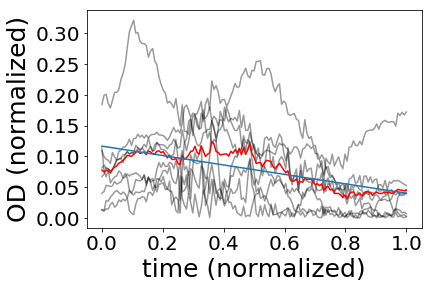

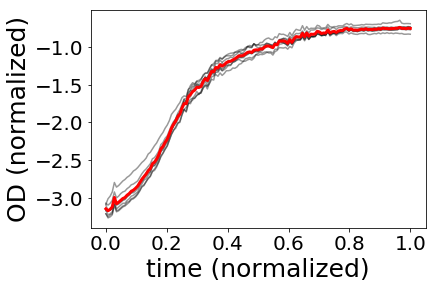

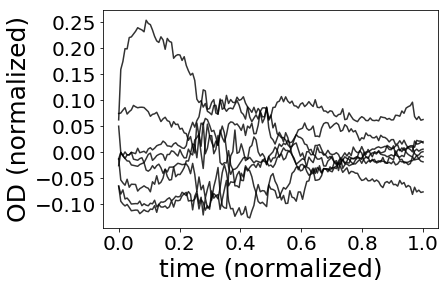

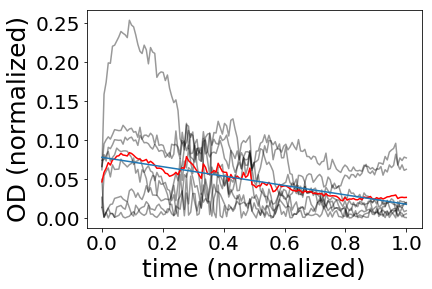

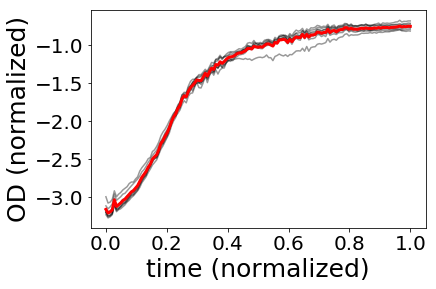

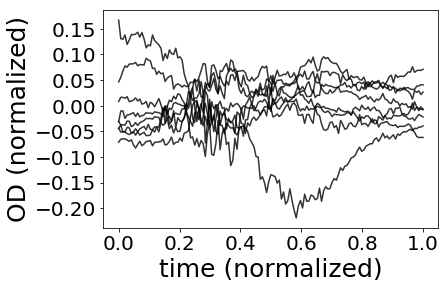

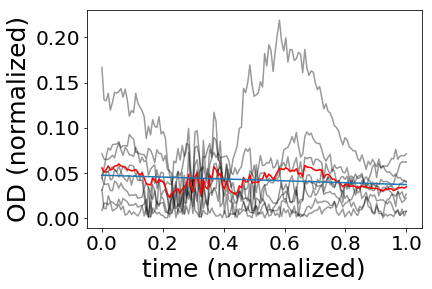

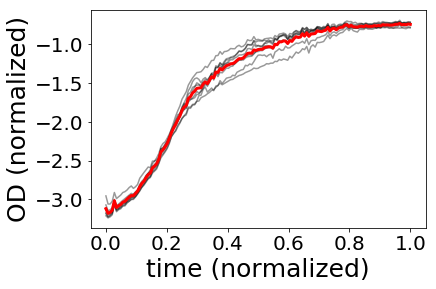

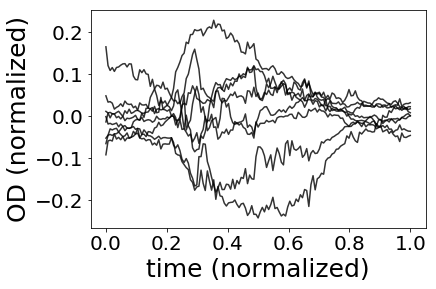

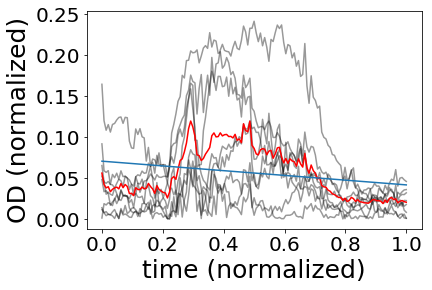

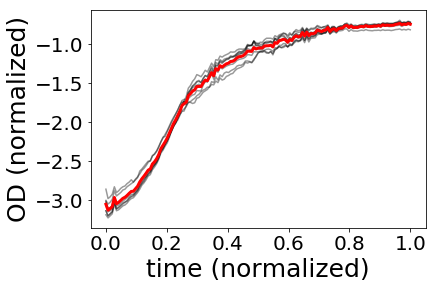

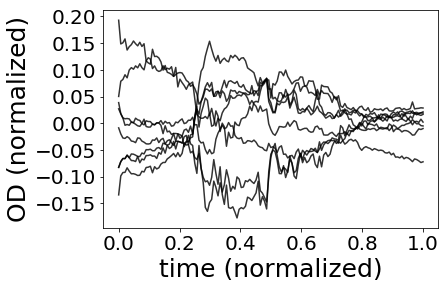

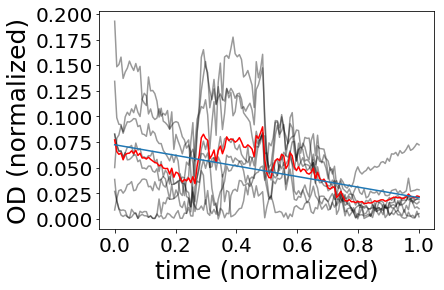

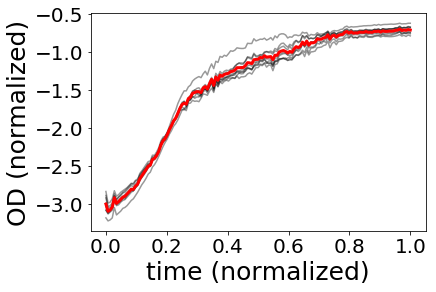

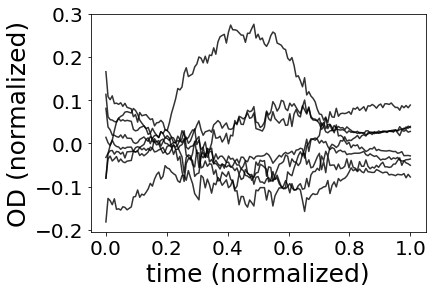

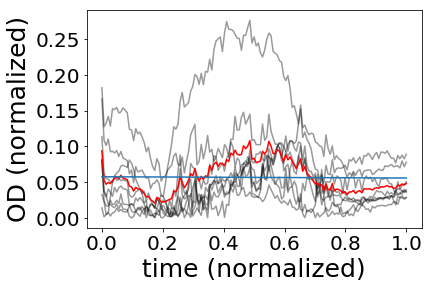

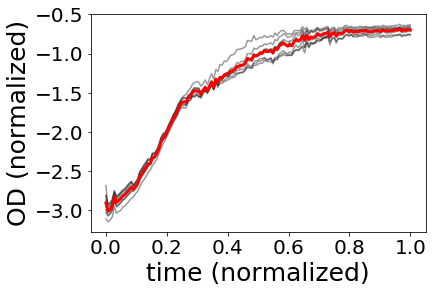

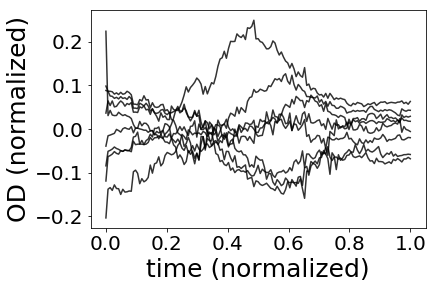

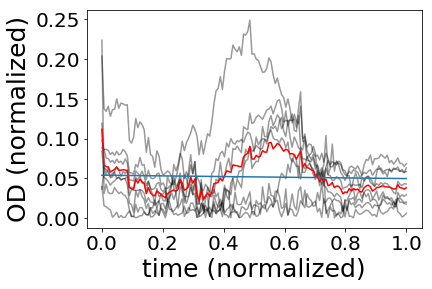

In [11]:
for bio in string.ascii_uppercase[:14]:

    ds = dataset.DataSet('data/')
    x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',Bio=bio,effects=['Well'])
    
    position = np.array(map(wellPosition,labels[0]))
    dist = np.column_stack((position.min(1),(9-position).min(1))).min(1)
    select = dist != 0
    y = y[:,select]
    
    if sum(select) ==0:
        continue
    
#     if string.ascii_uppercase.index(bio) in [6,8,10,12]:
#         y = y[:,1:]
    
    y = np.log2(y)

    plt.figure()
    plt.plot(x,y,c='k',alpha=.4); plt.plot(x,y.mean(1),c='r',lw=3);
    plt.xlabel("time (normalized)",fontsize=25)
    plt.ylabel("OD (normalized)",fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.savefig("figures/data-singleReplicate-%s.pdf"%bio,bbox_inches='tight',dpi=300)
    
    plt.figure(figsize=(6,4))
    plt.plot(x,y-y.mean(1)[:,None],c='k',alpha=.8)

    plt.xlabel("time (normalized)",fontsize=25)
    plt.ylabel("OD (normalized)",fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.savefig("figures/residuals-singleReplicate-%s.pdf"%bio,bbox_inches='tight')
    
    plt.figure(figsize=(6,4))
    resid = y-y.mean(1)[:,None]
    plt.plot(x,abs(resid),c='k',alpha=.4);
    plt.plot(x,abs(resid).mean(1),c='r',alpha=1);

    A = np.ones((x.shape[0],2))
    A[:,1] = x[:,0]
    beta,_,_,_ = np.linalg.lstsq(A,abs(resid).mean(1))
    plt.plot(x,np.dot(A,beta))

    plt.xlabel("time (normalized)",fontsize=25)
    plt.ylabel("OD (normalized)",fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.savefig("figures/residual-mean-singleReplicate-%s.pdf"%bio,bbox_inches='tight')

In [24]:
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',effects=['Well','Bio'])

x = x[6:,:]
y = y[6:,:]

In [28]:
position = np.array(map(wellPosition,labels[0]))
dist = np.column_stack((position.min(1),(9-position).min(1))).min(1)

effect['edge'] = dist==0
effect.head()

Well  Bio   edge
1      0    0   True
2      1    0   True
3      2    0   True
23     3    1  False
24     4    1  False

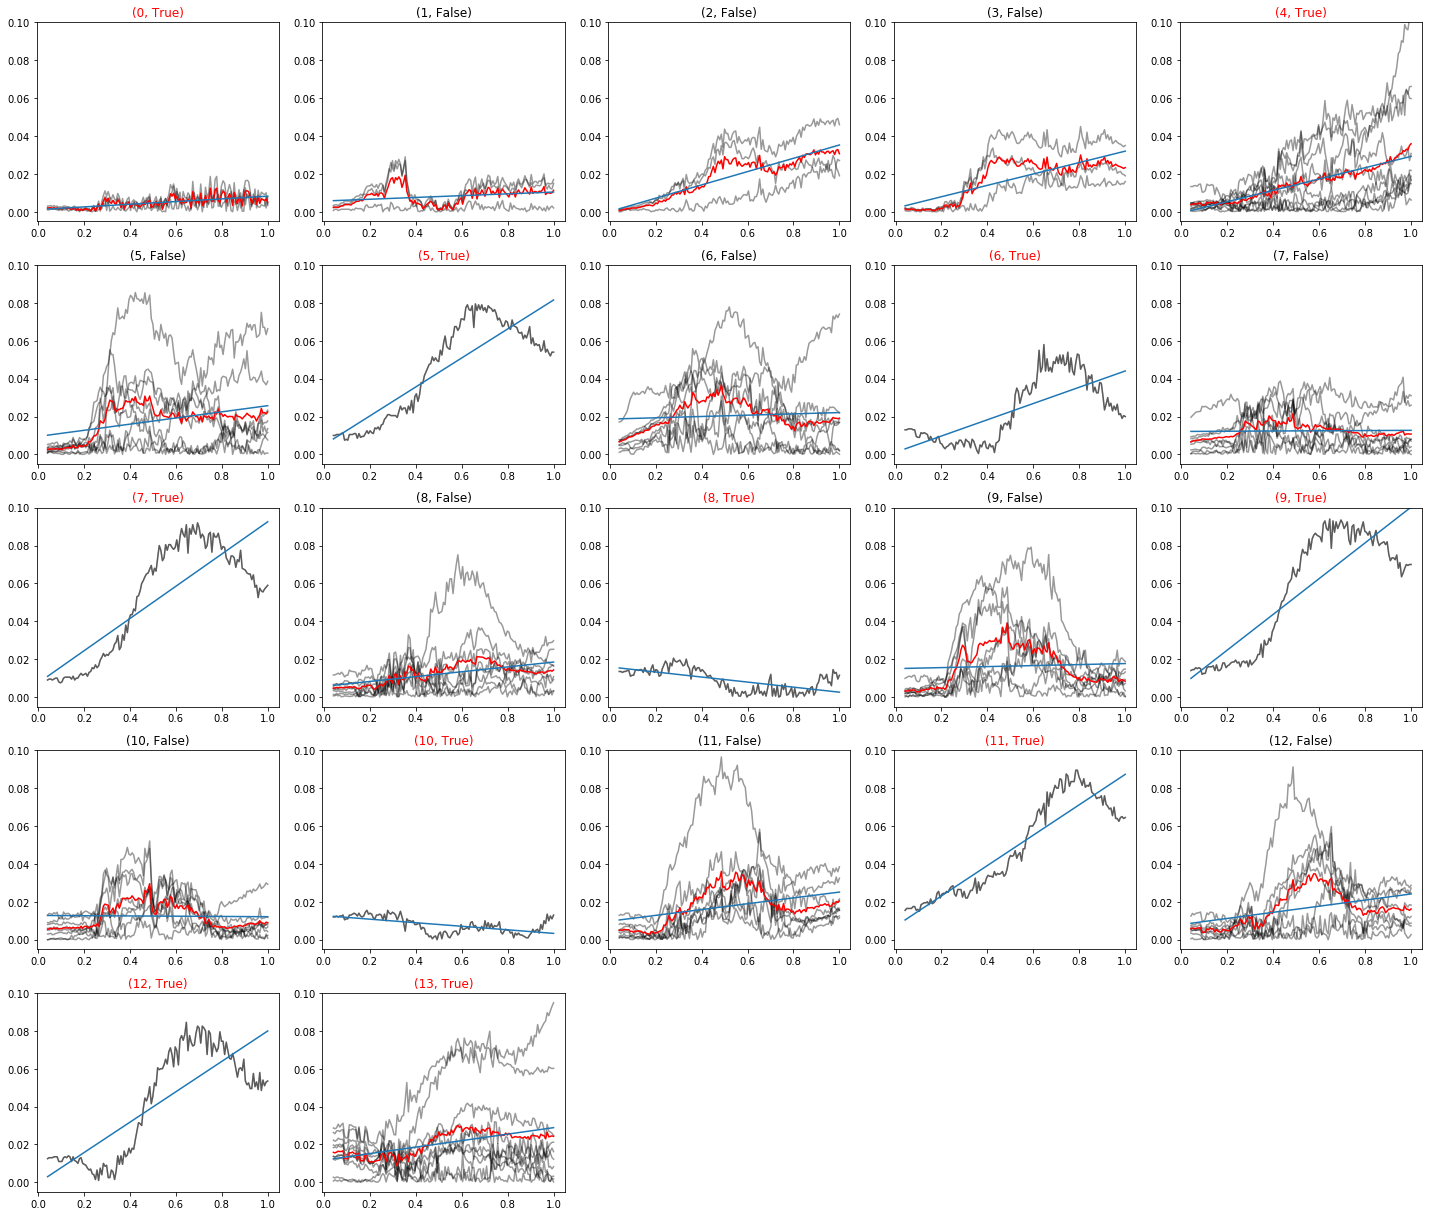

In [47]:
effect.index = range(effect.shape[0])
g = effect.groupby(['Bio','edge'])

keys = g.groups.keys()
keys.sort()

plt.figure(figsize=(5*4,len(keys)*4/5))
for i,k in enumerate(keys):
    ind = g.get_group(k).index
    
    plt.subplot(len(keys)/5+1,5,i+1)
    
    if k[1]:
        plt.title(k,color='r')
    else:
        plt.title(k,color='k')   
    
    resid = y[:,ind]-y[:,ind].mean(1)[:,None]
    plt.plot(x,abs(resid),c='k',alpha=.4);
    
    if resid.shape[1] > 2:
        plt.plot(x,abs(resid).mean(1),c='r',alpha=1);

    A = np.ones((x.shape[0],2))
    A[:,1] = x[:,0]
    beta,_,_,_ = np.linalg.lstsq(A,abs(resid).mean(1))
    plt.plot(x,np.dot(A,beta))
    
    plt.ylim(-.005,.1)
    
plt.tight_layout()

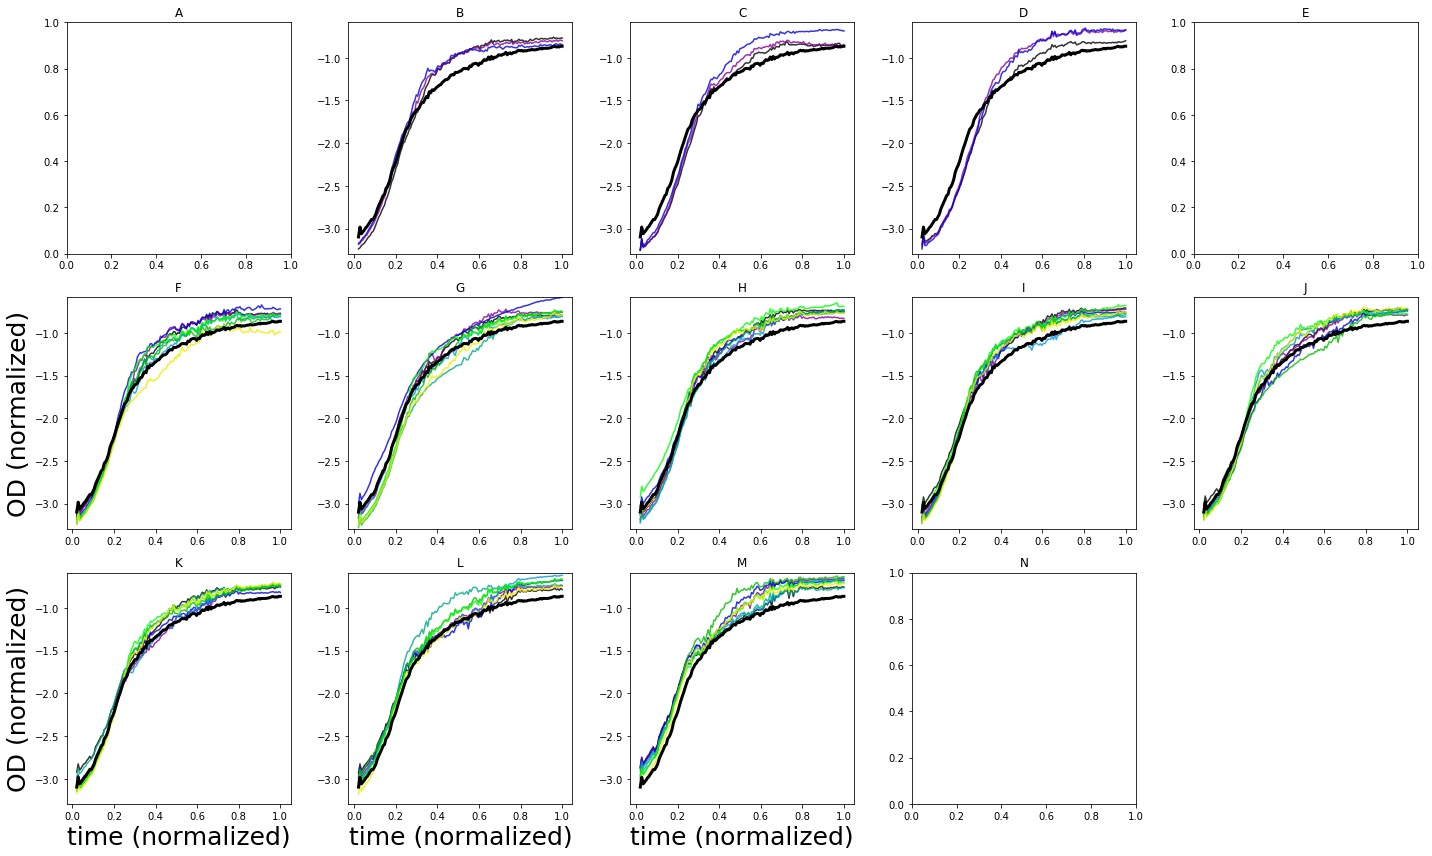

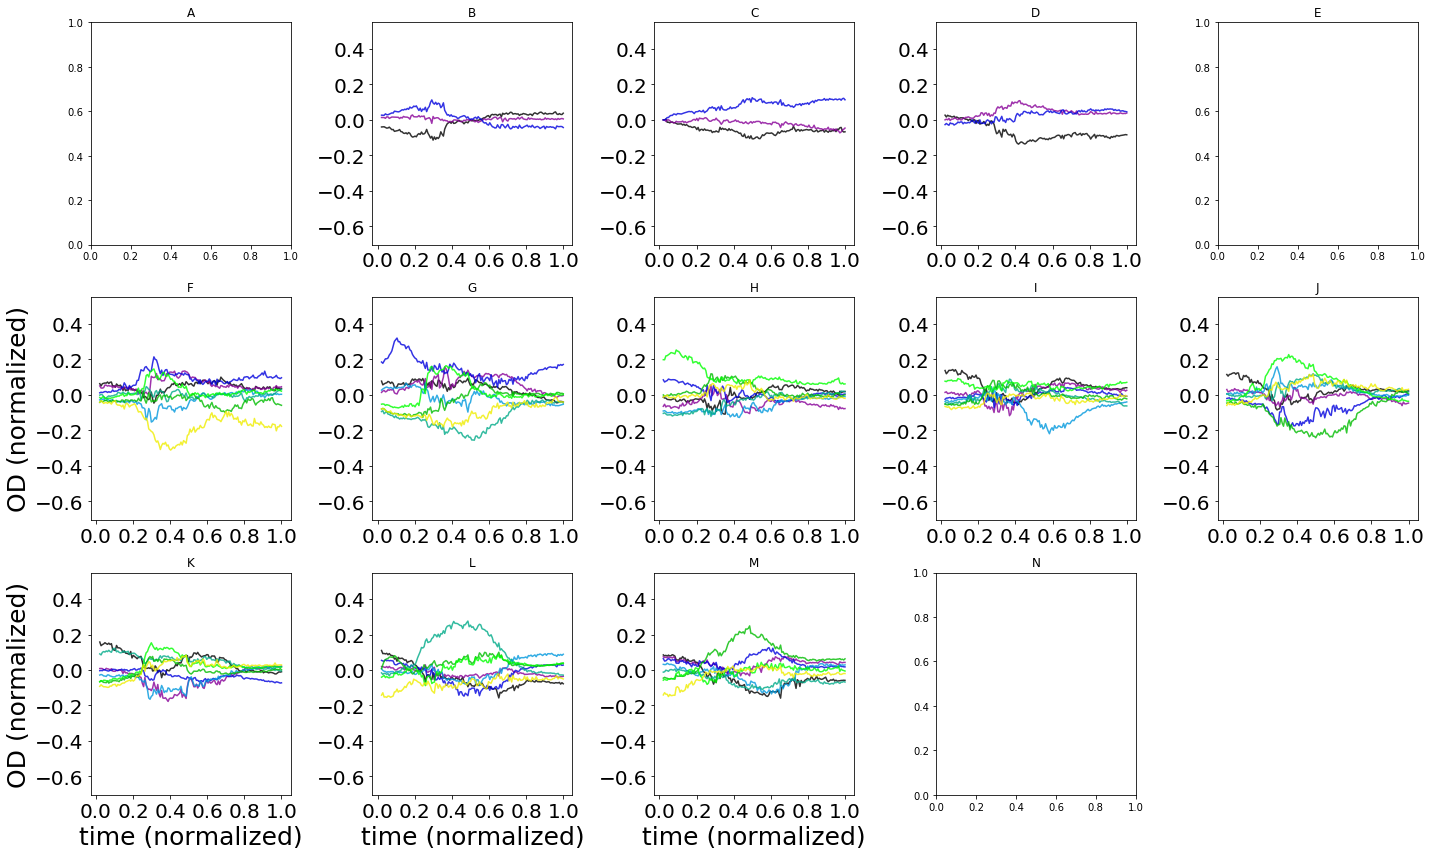

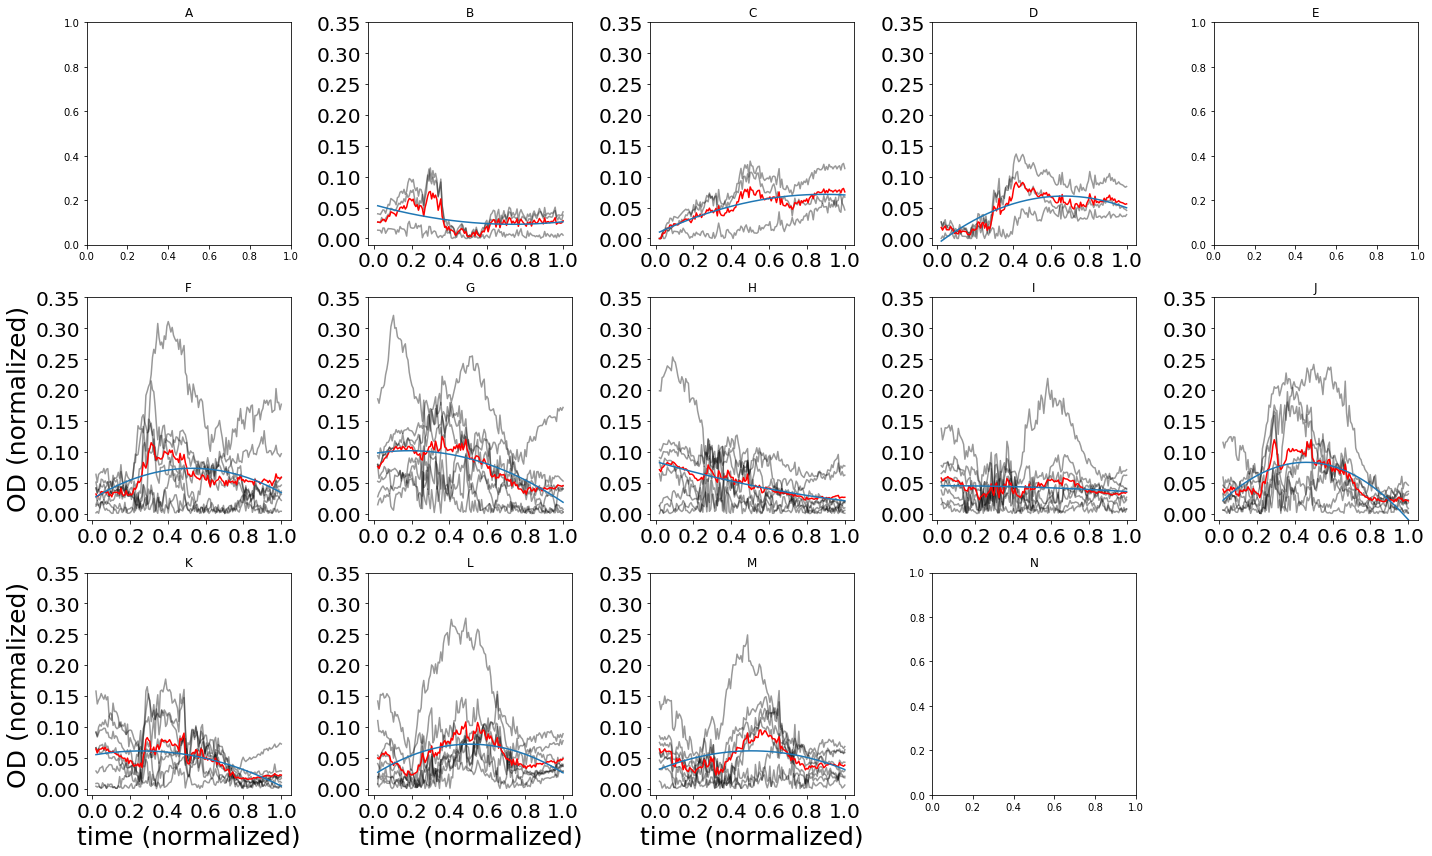

In [20]:
ds = dataset.DataSet('data/')
_,yall,_,_ = ds.build(Strain='ura3',mM_PQ=0.0,scale='range')
yall = yall[3:,:]
yall = np.log2(yall)
#yall = yall-yall[0,:]
cmap = plt.get_cmap("spectral")

for _type in ['data','residual','residual-mean']:
    plt.figure(figsize=(20,12))
    for i,bio in enumerate(string.ascii_uppercase[:14]):
        plt.subplot(3,5,i+1)
        plt.title(bio)

        
        x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',Bio=bio,effects=['Tech','Well'])
        x = x[3:,:]
        y = y[3:,:]
        y = np.log2(y)
        
        position = np.array(map(wellPosition,labels[1]))
        dist = np.column_stack((position.min(1),(9-position).min(1))).min(1)
        select = dist != 0
        y = y[:,select]

        if sum(select) ==0:
            continue
        #y = y-y[0,:]

    #     if string.ascii_uppercase.index(bio) in [6,8,10,12]:
    #         y = y[:,1:]
#         if y.shape[1] > 3:
#             y = y[:,1:-1]

#         y = (y-y.mean())/y.std()

        if _type == 'data':
            for j in range(y.shape[1]):
                plt.plot(x,y[:,j],c=cmap(1.*j/10),alpha=.8)
            plt.plot(x,yall.mean(1),c='k',lw=3)
            plt.ylim(yall.min(),yall.max())
            
            #plt.plot(x,y,c='k',alpha=.4); plt.plot(x,y.mean(1),c='r',lw=3);
            #plt.xticks(np.arange(.2,1,.2),fontsize=20)
            #plt.yticks(np.arange(-2,2,.5),fontsize=20)


        elif _type == 'residual':
            cmap = plt.get_cmap("spectral")
            
            for j in range(y.shape[1]):
                plt.plot(x,y[:,j]-y.mean(1),c=cmap(1.*j/10),alpha=.8)
            #plt.plot(x,y-y.mean(1)[:,None],alpha=.8)

            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.ylim((yall-yall.mean(1)[:,None]).min(),(yall-yall.mean(1)[:,None]).max())

        else:
            resid = y-y.mean(1)[:,None]
            plt.plot(x,abs(resid),c='k',alpha=.4);
            plt.plot(x,abs(resid).mean(1),c='r',alpha=1);

            A = np.ones((x.shape[0],3))
            A[:,1] = x[:,0]
            A[:,2] = x[:,0]**2
            beta,_,_,_ = np.linalg.lstsq(A,abs(resid).mean(1))
            plt.plot(x,np.dot(A,beta))

            #plt.ylim((ds.data-ds.data.mean(1)).max(1).abs().min(),(ds.data-ds.data.mean(1)).max(1).abs().max())
            plt.ylim(-.01,.35)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            
        if i >= 10:
            plt.xlabel("time (normalized)",fontsize=25)
        if i % 5 == 0:
            plt.ylabel("OD (normalized)",fontsize=25)

    plt.tight_layout()
    if _type == 'data':
        plt.savefig("figures/data-singleReplicate-all.pdf")
    elif _type == 'residual':
        plt.savefig("figures/residual-singleReplicate-all.pdf")
    else:
        plt.savefig("figures/residual-mean-singleReplicate-all.pdf")

0.40582999999999997

## Edge effect 

In [73]:
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',effects=['Well'])
y = np.log2(y)

In [74]:
labels

[[102,
  103,
  104,
  124,
  125,
  126,
  145,
  146,
  147,
  166,
  167,
  168,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300]]

In [93]:
edge = range(101,111) + range(111,191,10) + range(120,191,10) + range(191,201) + range(201,211) + range(211,291,10) + range(220,291,10) + range(291,301)
edge = np.array(edge)
edge

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 121, 131,
       141, 151, 161, 171, 181, 120, 130, 140, 150, 160, 170, 180, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 221, 231, 241, 251, 261,
       271, 281, 220, 230, 240, 250, 260, 270, 280, 290, 291, 292, 293,
       294, 295, 296, 297, 298, 299, 300])

In [94]:
position = []
for l in labels[0]:
    if l%10==0 or l%10==1 or l%100<10 or l%100>90:
        position.append(1)
    else:
        position.append(0)
zip(labels[0],position)

[(102, 1),
 (103, 1),
 (104, 1),
 (124, 0),
 (125, 0),
 (126, 0),
 (145, 0),
 (146, 0),
 (147, 0),
 (166, 0),
 (167, 0),
 (168, 0),
 (201, 1),
 (202, 1),
 (203, 1),
 (204, 1),
 (205, 1),
 (206, 1),
 (207, 1),
 (208, 1),
 (209, 1),
 (210, 1),
 (211, 1),
 (212, 0),
 (213, 0),
 (214, 0),
 (215, 0),
 (216, 0),
 (217, 0),
 (218, 0),
 (219, 0),
 (220, 1),
 (221, 1),
 (222, 0),
 (223, 0),
 (224, 0),
 (225, 0),
 (226, 0),
 (227, 0),
 (228, 0),
 (229, 0),
 (230, 1),
 (231, 1),
 (232, 0),
 (233, 0),
 (234, 0),
 (235, 0),
 (236, 0),
 (237, 0),
 (238, 0),
 (239, 0),
 (240, 1),
 (241, 1),
 (242, 0),
 (243, 0),
 (244, 0),
 (245, 0),
 (246, 0),
 (247, 0),
 (248, 0),
 (249, 0),
 (250, 1),
 (251, 1),
 (252, 0),
 (253, 0),
 (254, 0),
 (255, 0),
 (256, 0),
 (257, 0),
 (258, 0),
 (259, 0),
 (260, 1),
 (261, 1),
 (262, 0),
 (263, 0),
 (264, 0),
 (265, 0),
 (266, 0),
 (267, 0),
 (268, 0),
 (269, 0),
 (270, 1),
 (271, 1),
 (272, 0),
 (273, 0),
 (274, 0),
 (275, 0),
 (276, 0),
 (277, 0),
 (278, 0),
 (279, 0),

In [95]:
dist = np.array([min(abs(l-edge)) for l in labels[0]])

In [96]:
position = np.array(position)

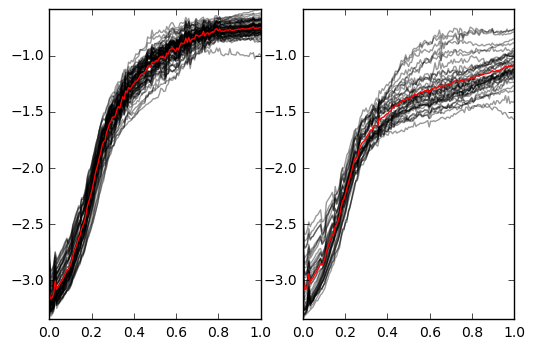

In [101]:
for i,p in enumerate([0,1]):
    plt.subplot(1,2,i+1)
    select = position==p
    plt.plot(x,y[:,select],c='k',alpha=.4)
    plt.plot(x,y[:,select].mean(1),c='r',alpha=1)
    plt.ylim(y.min(),y.max())
    
plt.savefig('figures/edgeEffect.pdf',bbox_inches='tight',dpi=300)

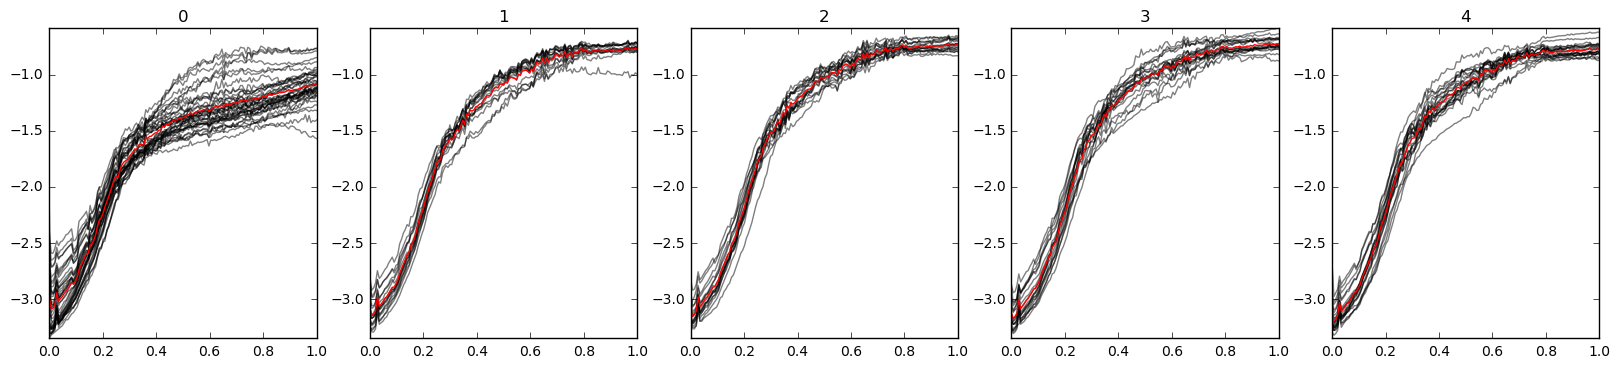

In [100]:
plt.figure(figsize=(20,4))
for i,p in enumerate(np.unique(dist)):
    plt.subplot(1,np.unique(dist).shape[0],i+1)
    plt.title(p)
    
    select = dist==p
    plt.plot(x,y[:,select],c='k',alpha=.5)
    plt.plot(x,y[:,select].mean(1),c='r',alpha=1)
    plt.ylim(y.min(),y.max())

# More data 

In [9]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',effects=['Bio','Tech'])

neffect = effect.Bio.unique().shape[0]
for e in range(neffect):
    select = effect.values[:,0] == e
    y[:,select] -= y[0,select].mean()
    
y = (y-y.mean())/y.std()

In [10]:
select = effect.Tech != 9
y = y[:,np.where(select)[0]]
effect = effect.loc[select,:]

In [11]:
for b in [6,8,10,12]:
    select = (effect != np.array([[b,0]])).values.any(1)
    
    y = y[:,np.where(select)[0]]
    effect = effect.loc[select,:]

In [12]:
y.shape

(145, 98)

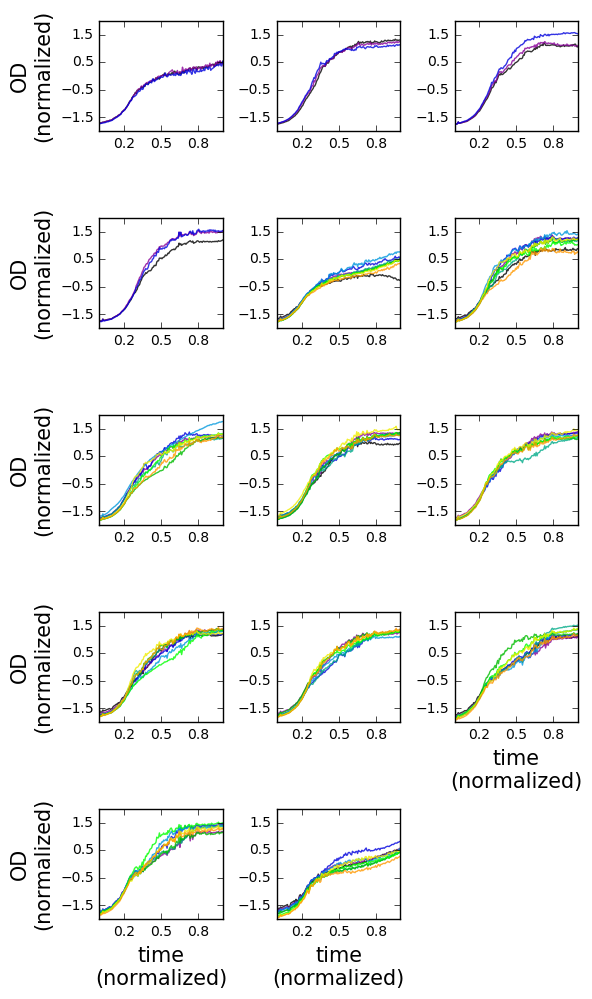

In [14]:
plt.figure(figsize=(6,10))

ncol = 3
cmap = plt.get_cmap('spectral')

for i in range(y.shape[1]):
    plt.subplot(neffect/ncol+1,ncol,effect.values[i,0]+1)
    #plt.plot(x,y[:,i],c=cmap(1.*effect.values[i,0]/neffect),alpha=.4);
    plt.plot(x,y[:,i],c=cmap(1.*effect.values[i,1]/10),alpha=.8,label=str(effect.values[i,1]));
    
    plt.ylim(-2,2)
    
for i in range(len(labels[0])):
    plt.subplot(neffect/ncol+1,ncol,i+1)
    #plt.title(labels[0][i])
    
    if i%ncol == 0:
        plt.yticks(np.arange(-1.5,2,1),fontsize=10)
        plt.ylabel("OD\n(normalized)",fontsize=15)
    else:
        plt.yticks(np.arange(-1.5,2,1),fontsize=10)
        
    if i >= 11:
        plt.xticks(np.arange(.2,1,.3),fontsize=10)
        plt.xlabel("time\n(normalized)",fontsize=15)
    else:
        plt.xticks(np.arange(.2,1,.3),fontsize=10)
    
plt.tight_layout()

plt.savefig("figures/data-multipleReplicates.pdf",bbox_inches='tight',dpi=300)

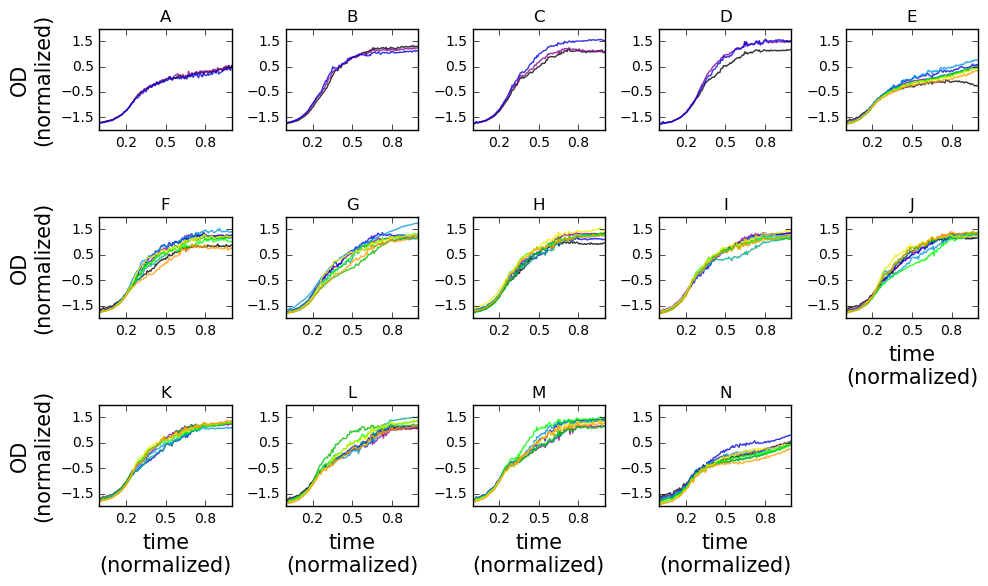

In [23]:
plt.figure(figsize=(10,6))

ncol = 5

for i in range(y.shape[1]):
    plt.subplot(neffect/ncol+1,ncol,effect.values[i,0]+1)
    #plt.plot(x,y[:,i],c=cmap(1.*effect.values[i,0]/neffect),alpha=.4);
    plt.plot(x,y[:,i],c=cmap(1.*effect.values[i,1]/10),alpha=.8,label=str(effect.values[i,1]));
    
    plt.ylim(-2,2)
    
for i in range(len(labels[0])):
    plt.subplot(neffect/ncol+1,ncol,i+1)
    plt.title(labels[0][i])
    
    if i%ncol == 0:
        plt.yticks(np.arange(-1.5,2,1),fontsize=10)
        plt.ylabel("OD\n(normalized)",fontsize=15)
    else:
        plt.yticks(np.arange(-1.5,2,1),fontsize=10)
        
    if i >= 9:
        plt.xticks(np.arange(.2,1,.3),fontsize=10)
        plt.xlabel("time\n(normalized)",fontsize=15)
    else:
        plt.xticks(np.arange(.2,1,.3),fontsize=10)
    
plt.tight_layout()

plt.savefig("figures/data-multipleReplicates-alt.pdf",bbox_inches='tight',dpi=300)

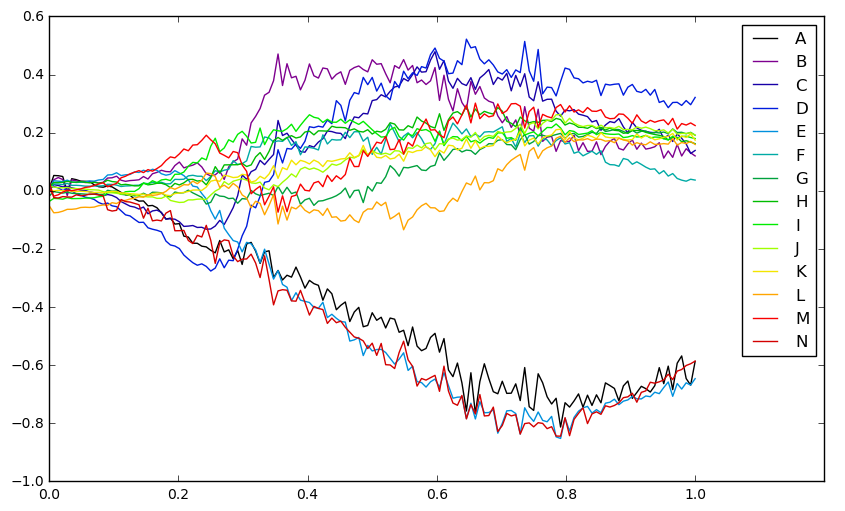

In [27]:
mu = y.mean(1)

plt.figure(figsize=(10,6))

for i,e in enumerate(effect.Bio.unique()):
    
    select = effect.Bio.values == e
    yselect = y[:,select]
    
    plt.plot(x,yselect.mean(1)-mu,c=cmap(1.*i/effect.Bio.unique().shape[0]),label=labels[0][e])
    
plt.xlim(x.min(),x.max()*1.2)
plt.legend()